In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir("/content/drive/My Drive/CA683")
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
import math
import xgboost as xgb



Mounted at /content/drive/


**1、Read Dataset**

In [ ]:
df = pd.read_csv('new.csv', encoding='gbk', low_memory=False)

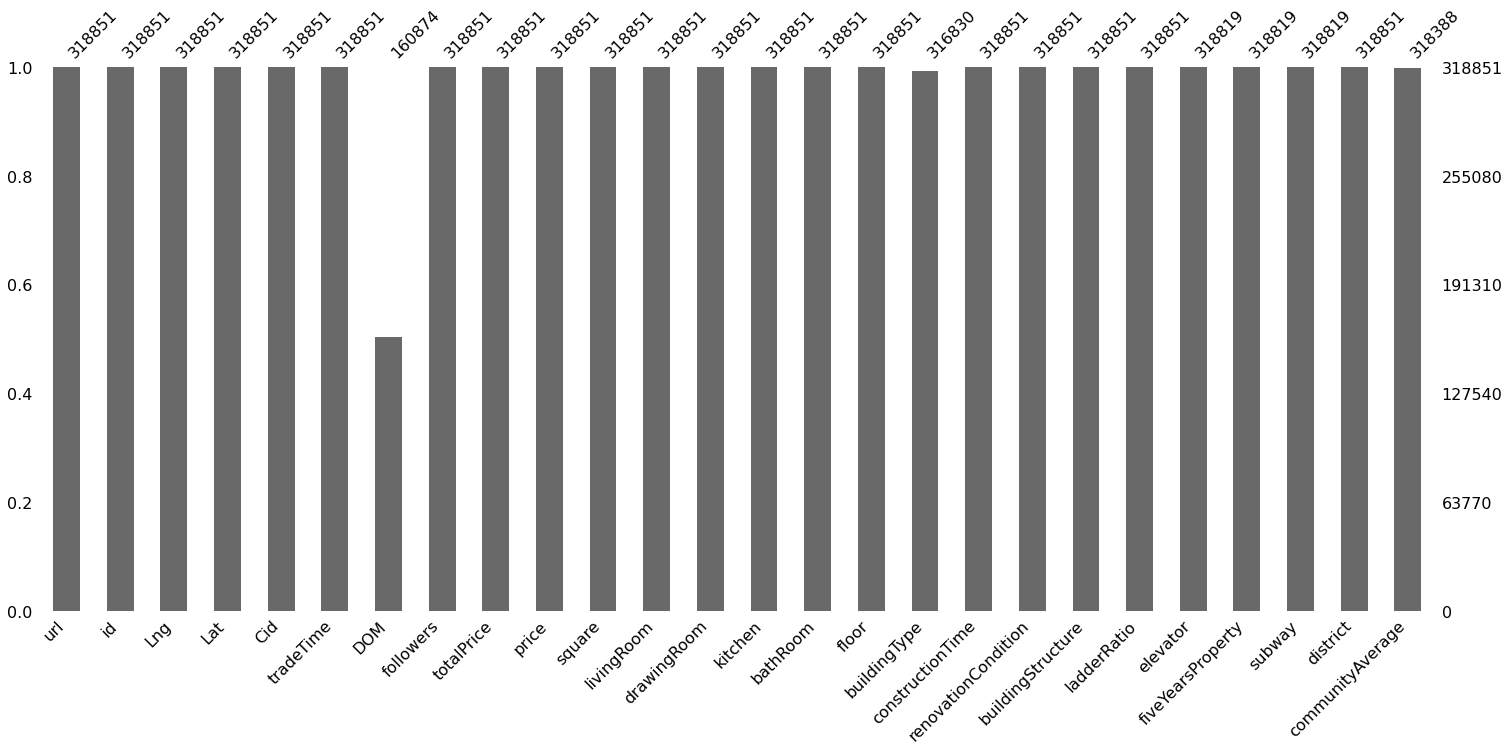

In [ ]:
# missing value bar chart
msno.bar(df)

**2、Clean Dataset**

In [ ]:
# drop filed 'DOM' beacause it has so many missing value
# drop filed 'totalPrice' because it is similar to our predicted target（price）
# drop these fileds('url', 'Cid', 'id', 'followers', 'district', 'communityAverage') beacuse they are unrelated with price
df = df.drop(['totalPrice', 'DOM', 'url', 'Cid', 'id', 'district', 'communityAverage'], axis=1)

In [ ]:
# drop mising value
df.dropna(inplace=True)
# drop value of constructionTime == '未知'
df = df[df['constructionTime']!='未知']

In [ ]:
df['tradeTime'] = pd.to_datetime(df['tradeTime'], format='%Y/%m/%d')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


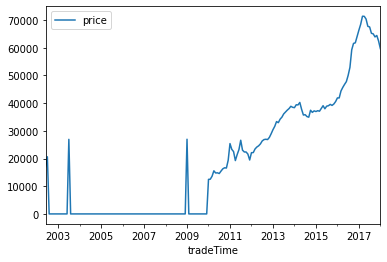

In [ ]:
# draw picture (x:tradeTime, y:price)
price_by_trade_time = pd.DataFrame()
price_by_trade_time['price'] = df['price']
price_by_trade_time.index = df['tradeTime'].astype('datetime64[ns]')
price_by_trade_month = price_by_trade_time.resample('M').mean().to_period('M').fillna(0)
price_by_trade_month.plot(kind='line')
plt.show()

In [ ]:
# As we can see from last plot, there aren't so many data before 2010-01-01,
# so I preserve the data after 2010-01-01
s_date = pd.to_datetime('2010-01-01', format='%Y/%m/%d')
df = df[df['tradeTime'] >= s_date]

# 'timeTrade' feature to year base only.
df['tradeTime'] = pd.DatetimeIndex(df['tradeTime']).year
print(len(df))

297985


In [ ]:
# Calculate the distance between Center of Beijing and Each house
def distance(lat2, lon2,lat1=39.9035,lon1=116.388): 
      
    # The math module contains a function named 
    # radians which converts from degrees to radians. 
    lon1 = radians(lon1) 
    lon2 = radians(lon2) 
    lat1 = radians(lat1) 
    lat2 = radians(lat2) 

    # Haversine formula  
    dlon = lon2 - lon1  
    dlat = lat2 - lat1 
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))  
     
    # Radius of earth in kilometers. Use 3956 for miles 
    r = 6371
       
    # calculate the result 
    return(c * r) 

df['distance'] = df.apply(lambda x: distance (x['Lat'],x['Lng']),axis=1)

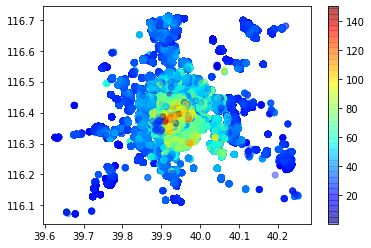

In [ ]:
# As we can see from the plot, The closer houses are to the city center, the higher the price
fig = plt.scatter(x=df['Lat'], y=df['Lng'], alpha=0.4, \
    c=df['price']/1000, cmap=plt.get_cmap('jet'))
plt.colorbar(fig)
plt.show()

In [ ]:
# We can drop 'lat' adn 'lng', Because we have distance to represent them 
df = df.drop(['Lat', 'Lng'], axis=1)

In [ ]:
# Creating "Age" feature by substrating from the threshold value "2022"
df['constructionTime'] = df['constructionTime'].astype(int)
df['age'] = 2022 - df['constructionTime']

In [ ]:
# split 'floor type' and 'floor height' from 'floor'
lst_numeric = []
lst_str = []
for value in df['floor'].values:
    value = value.split()
    numeric = (value[1])
    string  = value[0]
    lst_numeric.append(numeric)
    lst_str.append(string)

# Replacing Chinese language words with English words.    
lst_str_eng=[]
for string in lst_str:
    #print(string)
    if string == '中':
        lst_str_eng.append(string.replace('中','middle'))
    elif string == '高':
        lst_str_eng.append(string.replace('高','high'))
    elif string == '底':
        lst_str_eng.append(string.replace('底','bottom'))
    elif string == '低':
        lst_str_eng.append(string.replace('低','low'))
    elif string == '未知':
        lst_str_eng.append(string.replace('未知','unknown'))
    elif string == '顶':
        lst_str_eng.append(string.replace('顶','top'))

# Converting into DataFrame and stitching them
df1 = pd.DataFrame(lst_str_eng,columns=['floorType'])
df2 = pd.DataFrame(lst_numeric,columns=['floorHeight'])
df = pd.concat([df,df1,df2],axis=1)
# Deleting unknown values
df = df[df['floorType']!='unknown']
df = df.dropna(subset=['floorHeight'])
# Dropping features which are not much relevant now.
df.drop(['floor','constructionTime'],axis=1,inplace=True)

In [ ]:
# Converting 'renovationCondition' feature to string type
df['renovationCondition'].replace(1, 'Other', inplace=True)
df['renovationCondition'].replace(2, 'Rough', inplace=True)
df['renovationCondition'].replace(3, 'Simplicity', inplace=True)
df['renovationCondition'].replace(4, 'Hardcover', inplace=True)

In [ ]:
# Converting 'buildingType' feature to object or string type
df['buildingType'].replace(1,'Tower',inplace=True)
df['buildingType'].replace(2,'Bungalow',inplace=True)
df['buildingType'].replace(3,'Tower and Plate',inplace=True)
df['buildingType'].replace(4,'Plate',inplace=True)

In [ ]:
# Converting 'buildingStructure' feature to string type
df['buildingStructure'].replace(1, 'Unknown', inplace=True)
df['buildingStructure'].replace(2, 'mixed', inplace=True)
df['buildingStructure'].replace(3, 'brick and wood', inplace=True)
df['buildingStructure'].replace(4, 'brick and concrete', inplace=True)
df['buildingStructure'].replace(5, 'steel', inplace=True)
df['buildingStructure'].replace(6, 'steel-concrete composite', inplace=True)

In [ ]:
# Dropping missing data which can't be converted into real data
df.dropna(inplace=True)
# Due to some features' type is Object, we need convert features datatype
df['floorHeight'] = df['floorHeight'].astype(float)
df['livingRoom'] = df['livingRoom'].astype(float)
df['drawingRoom'] = df['drawingRoom'].astype(float)
df['bathRoom'] = df['bathRoom'].astype(float)
df['age'] = df['age'].astype(float)
df['kitchen'] = df['kitchen'].astype(float)
df['elevator'] = df['elevator'].astype(float)
df['fiveYearsProperty'] = df['fiveYearsProperty'].astype(bool)
df['subway'] = df['subway'].astype(float)
# Reseting the index
df.reset_index(inplace=True)
df.drop(['index'],axis=1,inplace=True)
# Now the remaining data
print ("DATA", df.shape)
df.head()

DATA (277915, 19)


tradeTime  followers    price  square  livingRoom  drawingRoom  kitchen  \
0     2016.0      106.0  31680.0  131.00         2.0          1.0      1.0   
1     2016.0      126.0  43436.0  132.38         2.0          2.0      1.0   
2     2016.0       48.0  52021.0  198.00         3.0          2.0      1.0   
3     2016.0      138.0  22202.0  134.00         3.0          1.0      1.0   
4     2016.0      286.0  48396.0   81.00         2.0          1.0      1.0   

   bathRoom buildingType renovationCondition         buildingStructure  \
0       1.0        Tower          Simplicity  steel-concrete composite   
1       2.0        Tower           Hardcover  steel-concrete composite   
2       3.0        Plate          Simplicity  steel-concrete composite   
3       1.0        Tower               Other  steel-concrete composite   
4       1.0        Plate               Rough                     mixed   

   ladderRatio  elevator  fiveYearsProperty  subway   distance   age  \
0        0.217       1.0              False     1.0  14.900718  17.0   
1        0.667       1.0               True     0.0   6.131178  18.0   
2        0.500       1.0              False     0.0  15.129791  17.0   
3        0.273       1.0              False     0.0  19.660972  14.0   
4        0.333       0.0               True     1.0   3.944907  62.0   

  floorType  floorHeight  
0      high         26.0  
1      high         22.0  
2    middle          4.0  
3    bottom         21.0  
4    middle          6.0

**4、Drop the outliers for each columns**

In [ ]:
df.describe()

tradeTime      followers          price         square  \
count  277915.000000  277915.000000  277915.000000  277915.000000   
mean     2014.826760      17.683115   42941.785643      83.570693   
std         1.689548      35.647057   21675.049172      35.820653   
min      2010.000000       0.000000       1.000000       7.800000   
25%      2013.000000       0.000000   27721.000000      58.450000   
50%      2015.000000       5.000000   38000.000000      75.180000   
75%      2016.000000      19.000000   52552.000000      99.200000   
max      2018.000000    1143.000000  150000.000000     640.000000   

          livingRoom    drawingRoom        kitchen       bathRoom  \
count  277915.000000  277915.000000  277915.000000  277915.000000   
mean        2.018409       1.180321       0.994721       1.188543   
std         0.764844       0.515732       0.103015       0.428463   
min         0.000000       0.000000       0.000000       0.000000   
25%         2.000000       1.000000       1.000000       1.000000   
50%         2.000000       1.000000       1.000000       1.000000   
75%         2.000000       1.000000       1.000000       1.000000   
max         8.000000       5.000000       3.000000       7.000000   

        ladderRatio       elevator         subway       distance  \
count  2.779150e+05  277915.000000  277915.000000  277915.000000   
mean   7.241763e+01       0.574733       0.593534      13.656791   
std    2.685136e+04       0.494384       0.491174       7.284080   
min    1.400000e-02       0.000000       0.000000       0.136697   
25%    2.500000e-01       0.000000       0.000000       8.156539   
50%    3.330000e-01       1.000000       1.000000      12.030832   
75%    5.000000e-01       1.000000       1.000000      18.489973   
max    1.000940e+07       1.000000       1.000000      44.623722   

                 age    floorHeight  
count  277915.000000  277915.000000  
mean       22.456596      13.170023  
std         8.523099       7.764609  
min         6.000000       1.000000  
25%        16.000000       6.000000  
50%        20.000000      11.000000  
75%        28.000000      19.000000  
max        78.000000      63.000000

In [ ]:
# For 'distance' Outliers
outliers_dist = []
Q1 =  7.821041
Q3 = 17.444622
IQR = Q3 - Q1
for x in df['distance'].values:
    if (x < (Q1 - 1.5 * IQR)) or ((Q3 + 1.5 * IQR) < x):
        if x not in outliers_dist:
            outliers_dist.append(x)

#print (sorted(outliers_dist))
for outlier in outliers_dist:
    df = df[df['distance']!=outlier]
print ('DATA' ,df.shape)

DATA (269588, 19)


In [ ]:
# For 'Age' Outliers
outliers_age = []
Q1 = 13
Q3 = 25
IQR = Q3 - Q1
for x in df['age'].values:
    if (x < (Q1 - 1.5 * IQR)) or ((Q3 + 1.5 * IQR) < x):
        if x not in outliers_age:
            outliers_age.append(x)

#print (sorted(outliers_age))
for outlier in outliers_age:
    df = df[df['age']!=outlier]
print ("DATA" ,df.shape)

DATA (266647, 19)


In [ ]:
# For 'square' Outliers
outliers_square = []
Q1 = 58.280000
Q3 = 99.330000
IQR = Q3 - Q1
for x in df['square'].values:
    if (x < (Q1 - 1.5 * IQR)) or ((Q3 + 1.5 * IQR) < x):
        if x not in outliers_square:
            outliers_square.append(x)

#print (sorted(outliers_square))
for outlier in outliers_square:
    df = df[df['square']!=outlier]
print ('DATA', df.shape)

DATA (257226, 19)


In [ ]:
# For 'ladderRatio' Outliers
outliers_ladderRatio = []
Q1 = 2.500000e-01
Q3 = 5.000000e-01
IQR = Q3 - Q1
for x in df['ladderRatio'].values:
    if (x < (Q1 - 1.5 * IQR)) or ((Q3 + 1.5 * IQR) < x):
        if x not in outliers_ladderRatio:
            outliers_ladderRatio.append(x)

#print (sorted(outliers_ladderRatio))
for outlier in outliers_ladderRatio:
    df = df[df['ladderRatio']!=outlier]
print ('DATA', df.shape)

DATA (252995, 19)


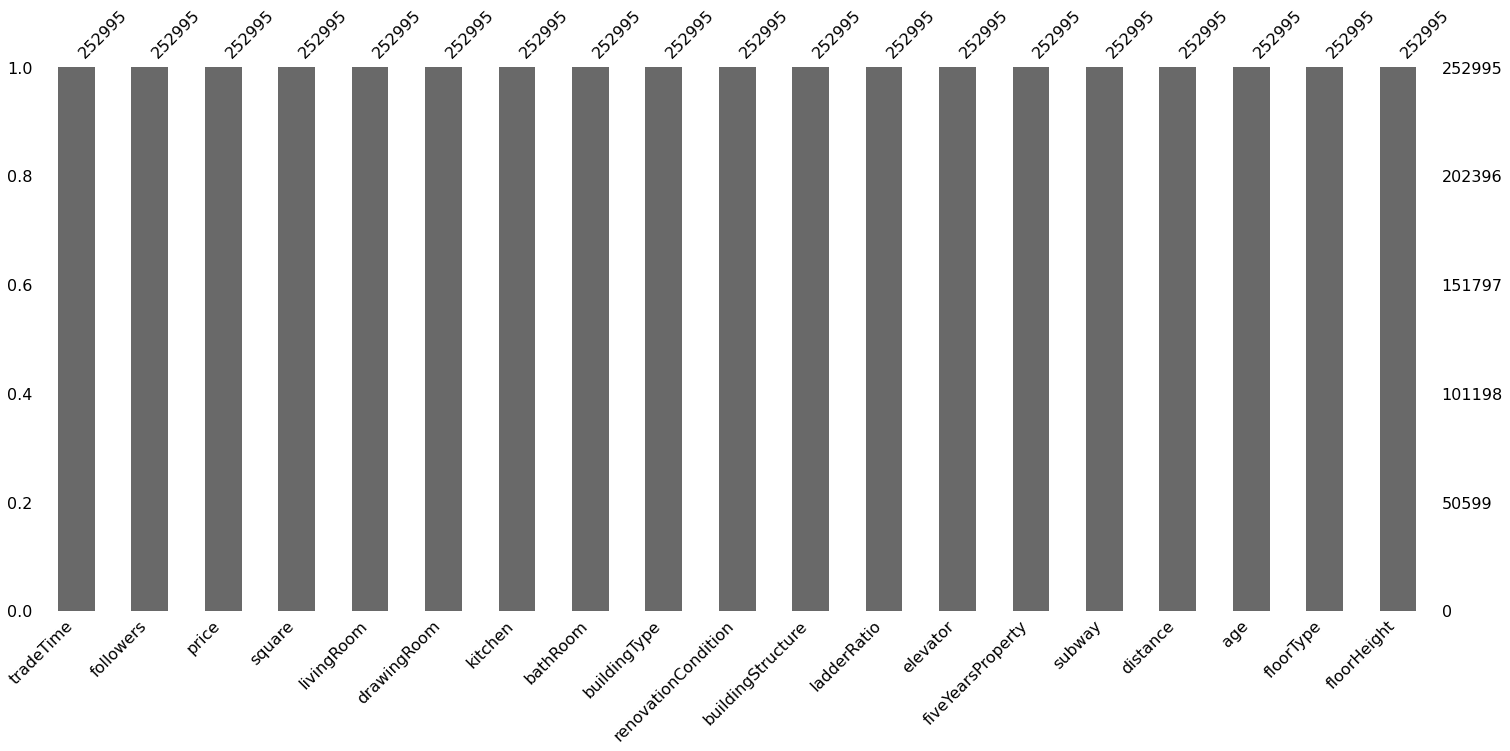

In [ ]:
msno.bar(df)

In [ ]:
df.corr()

tradeTime  followers     price    square  livingRoom  \
tradeTime           1.000000   0.403275  0.571430 -0.022146   -0.002684   
followers           0.403275   1.000000  0.283726 -0.056798   -0.004402   
price               0.571430   0.283726  1.000000 -0.196612   -0.072352   
square             -0.022146  -0.056798 -0.196612  1.000000    0.687935   
livingRoom         -0.002684  -0.004402 -0.072352  0.687935    1.000000   
drawingRoom        -0.081091  -0.057491 -0.123107  0.607013    0.429966   
kitchen             0.034862   0.012251  0.036480  0.063275    0.075943   
bathRoom           -0.012772  -0.033192 -0.082366  0.652828    0.452964   
ladderRatio        -0.005629  -0.038621 -0.126715  0.358146    0.311155   
elevator            0.020466  -0.016921  0.057692  0.173409   -0.111651   
fiveYearsProperty   0.010295   0.046490 -0.015630  0.023849    0.073745   
subway             -0.002630   0.023230  0.218422 -0.105877   -0.052215   
distance            0.003250  -0.033394 -0.447773  0.229686    0.099938   
age                -0.036136   0.022578  0.185774 -0.388332    0.049732   
floorHeight        -0.010759   0.002663 -0.020224 -0.005350   -0.006654   

                   drawingRoom   kitchen  bathRoom  ladderRatio  elevator  \
tradeTime            -0.081091  0.034862 -0.012772    -0.005629  0.020466   
followers            -0.057491  0.012251 -0.033192    -0.038621 -0.016921   
price                -0.123107  0.036480 -0.082366    -0.126715  0.057692   
square                0.607013  0.063275  0.652828     0.358146  0.173409   
livingRoom            0.429966  0.075943  0.452964     0.311155 -0.111651   
drawingRoom           1.000000  0.110589  0.469715     0.315085  0.027168   
kitchen               0.110589  1.000000  0.089133     0.038450 -0.010480   
bathRoom              0.469715  0.089133  1.000000     0.211579  0.104449   
ladderRatio           0.315085  0.038450  0.211579     1.000000 -0.317338   
elevator              0.027168 -0.010480  0.104449    -0.317338  1.000000   
fiveYearsProperty     0.031948  0.061157 -0.003735    -0.009362 -0.113267   
subway               -0.084691  0.026392 -0.055871    -0.157487  0.106232   
distance              0.134186 -0.048348  0.128701     0.290932 -0.111884   
age                  -0.172233  0.032619 -0.236382    -0.126828 -0.457945   
floorHeight           0.004105  0.009574 -0.002880    -0.003880  0.023834   

                   fiveYearsProperty    subway  distance       age  \
tradeTime                   0.010295 -0.002630  0.003250 -0.036136   
followers                   0.046490  0.023230 -0.033394  0.022578   
price                      -0.015630  0.218422 -0.447773  0.185774   
square                      0.023849 -0.105877  0.229686 -0.388332   
livingRoom                  0.073745 -0.052215  0.099938  0.049732   
drawingRoom                 0.031948 -0.084691  0.134186 -0.172233   
kitchen                     0.061157  0.026392 -0.048348  0.032619   
bathRoom                   -0.003735 -0.055871  0.128701 -0.236382   
ladderRatio                -0.009362 -0.157487  0.290932 -0.126828   
elevator                   -0.113267  0.106232 -0.111884 -0.457945   
fiveYearsProperty           1.000000  0.046538 -0.090652  0.223975   
subway                      0.046538  1.000000 -0.336508  0.159044   
distance                   -0.090652 -0.336508  1.000000 -0.354417   
age                         0.223975  0.159044 -0.354417  1.000000   
floorHeight                -0.007205  0.006006 -0.015902 -0.003043   

                   floorHeight  
tradeTime            -0.010759  
followers             0.002663  
price                -0.020224  
square               -0.005350  
livingRoom           -0.006654  
drawingRoom           0.004105  
kitchen               0.009574  
bathRoom             -0.002880  
ladderRatio          -0.003880  
elevator              0.023834  
fiveYearsProperty    -0.007205  
subway                0.006006  
distance             -0.015902  
ag

**3、Data process**

In [ ]:
# Beacause 'buildingType' and 'floorType' are string, we need encode these two features
# Label Encoding of Categorical Features
lbl = LabelEncoder()
# 'floorType'
lbl.fit(list(df['floorType'].values) + list(df['floorType'].values))
df['floorType'] = lbl.transform(list(df['floorType'].values))
# 'buildingType'
lbl.fit(list(df['buildingType'].values) + list(df['buildingType'].values))
df['buildingType'] = lbl.transform(list(df['buildingType'].values))

lbl.fit(list(df['renovationCondition'].values) + list(df['renovationCondition'].values))
df['renovationCondition'] = lbl.transform(list(df['renovationCondition'].values))

lbl.fit(list(df['buildingStructure'].values) + list(df['buildingStructure'].values))
df['buildingStructure'] = lbl.transform(list(df['buildingStructure'].values))

In [ ]:
# devide train dataset and test dataset
X = df.drop(['price'], axis=1)

# Standardized the Features
X = np.asarray(X)
sc = StandardScaler()
X = sc.fit(X).transform(X)  

# Selecting Target Feature
y =  np.asarray(df['price'])#.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**4、Train model**

In [ ]:
r2_list = []

In [ ]:
def calculate_value(y_test, y_pred):
  mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
  rmse = math.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
  mae = mean_absolute_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  return mse, rmse, mae, r2


**Random Forest**

In [ ]:
# Search optimal hyperparameter
# Set hyperparameter dict
# n_estimators_range=[int(x) for x in np.linspace(start=50,stop=1000,num=20)]
n_estimators_range=[50, 100, 500, 1000]
max_features_range=['auto','sqrt']
max_depth_range=[int(x) for x in np.linspace(start=10,stop=210,num=10)]
# max_depth_range.append(None)
min_samples_split_range=[2,5,10]
min_samples_leaf_range=[1,2,4,8]

random_forest_hp_range={'n_estimators':n_estimators_range,
                        'max_features':max_features_range,
                        'max_depth':max_depth_range,
                        'min_samples_split':min_samples_split_range,
                        'min_samples_leaf':min_samples_leaf_range
                        }
print(random_forest_hp_range)

In [ ]:
#Random Search
random_seed=44
random_forest_seed=np.random.randint(low=1,high=230)
random_forest_model_test_base=RandomForestRegressor()
random_forest_model_test_random=RandomizedSearchCV(estimator=random_forest_model_test_base,
                                                   param_distributions=random_forest_hp_range,
                                                   n_iter=10,
                                                   n_jobs=-1,
                                                   cv=3,
                                                   verbose=1,
                                                   random_state=random_forest_seed
                                                    )
random_forest_model_test_random.fit(X_train, y_train)

best_hp_now=random_forest_model_test_random.best_params_
print(best_hp_now)

In [ ]:
# Grid Search

random_forest_hp_range_2={'n_estimators':[900,1000],
                          'max_features':[15,16],
                          'max_depth':[50,60],
                          'min_samples_split':[5,6], # Greater than 1
                          'min_samples_leaf':[4]
                          # 'bootstrap':bootstrap_range
                          }
random_forest_model_test_2_base=RandomForestRegressor()
random_forest_model_test_2_random=GridSearchCV(estimator=random_forest_model_test_2_base,
                                               param_grid=random_forest_hp_range_2,
                                               cv=3,
                                               verbose=1,
                                               n_jobs=-1)
random_forest_model_test_2_random.fit(X_train,y_train)

best_hp_now_2=random_forest_model_test_2_random.best_params_
print(best_hp_now_2)

In [ ]:
# Model Trainng For Test Data
# Specify Model
rf = RandomForestRegressor(random_state=42,n_estimators=1000,max_depth=54,n_jobs=-1,min_samples_split=5,min_samples_leaf=4)
# Fit Model
rf.fit(X_train, y_train.ravel())
# Make validation predictions
rf_y_pred = rf.predict(X_test)


In [ ]:
rf_mse, rf_rmse, rf_mae, rf_r2 = calculate_value(y_test, rf_y_pred)
r2_list.append(rf_r2)
# Rodom Forest Model Evaluation
print("MSE:", rf_mse)
print("RMSE:", rf_rmse)
print("MAE:", rf_mae)
print("R² score:", rf_r2)

In [ ]:
sns.set(rc={'figure.figsize':(12.7,8.27)})
ax = sns.regplot(rf_y_pred,y_test,color = 'blue',line_kws={'color':'orange'})#,hue='y_test')

ax.set(xlabel="Random Forest Prediction", ylabel = "Actual Price",title = "RANDOM FOREST RESULTS")
ax.legend(['Line of Best Fit', 'Housing Price'], loc='lower right')

**XGB**

In [ ]:

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', min_child_weight = 2, subsample = 1,
                          colsample_bytree = 0.8,
                          learning_rate = 0.2, n_estimators = 500,
                         reg_lambda = 0.45, reg_alpha = 0, gamma = 0.5)
xg_reg.fit(X_train, y_train)
xgb_y_pred = xg_reg.predict(X_test)

In [ ]:
xgb_mse, xgb_rmse, xgb_mae, xgb_r2 = calculate_value(y_test, xgb_y_pred)
print("MSE:", xgb_mse)
print("RMSE:", xgb_rmse)
print("MAE:", xgb_mae)
print("R² score:", xgb_r2)

**GBDT**

In [ ]:
n_estimators_range=[50, 100, 500, 1000]
max_features_range=['auto','sqrt']
max_depth_range=[int(x) for x in np.linspace(start=10,stop=210,num=10)]
# max_depth_range.append(None)
min_samples_split_range=[2,5,10]
min_samples_leaf_range=[1,2,4,8]

random_forest_hp_range={'n_estimators':n_estimators_range,
                        'max_features':max_features_range,
                        'max_depth':max_depth_range,
                        'min_samples_split':min_samples_split_range,
                        'min_samples_leaf':min_samples_leaf_range
                        }
print(random_forest_hp_range)

In [ ]:
random_seed=44
gbt_seed=np.random.randint(low=1,high=230)
parameters = {'loss': ['ls','lad','huber','quantile'],'min_samples_leaf': [1,2,3,4,5], 'n_estimators':[50,100,500,1000,1500]}
gbt_model = GradientBoostingRegressor()
gbt_model_test_random=RandomizedSearchCV(estimator=gbt_model,
                                                   param_distributions=parameters,
                                                   n_iter=30,
                                                   n_jobs=-1,
                                                   cv=3,
                                                   verbose=1,
                                                   random_state=gbt_seed
                                                    )
gbt_model_test_random.fit(X_train, y_train)

best_hp_now=gbt_model_test_random.best_params_
print(best_hp_now)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,


{'n_estimators': 1500, 'min_samples_leaf': 5, 'loss': 'ls'}


In [ ]:

parameters = {'loss': ['ls'],'min_samples_leaf': [4,5], 'n_estimators':[1400,1500]}

model_gbr = GradientBoostingRegressor()
model_gs = GridSearchCV(estimator=model_gbr, param_grid=parameters, cv=3)
model_gs.fit(X_train,y_train)
print('Best score is:', model_gs.best_score_)
print('Best parameter is:', model_gs.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in v

In [ ]:

model = Sequential()  
model.add(Dense(units = 10,   
                activation='relu',  
                input_shape=(X_train.shape[1],)  
               )
         )

model.add(Dropout(0.2))  

model.add(Dense(units = 15, activation='relu'))


model.add(Dense(units = 1, activation='linear'))
print(model.summary())  

model.compile(loss='mse', optimizer='adam')

history = model.fit(X_train, y_train,
          epochs=200,  
          batch_size=200,  
          verbose=2,  
          validation_data = (X_test, y_test)  
        )


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 10)                190       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 15)                165       
                                                                 
 dense_4 (Dense)             (None, 1)                 16        
                                                                 
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
1012/1012 - 2s - loss: 2290466048.0000 - val_loss: 2136595328.0000 - 2s/epoch - 2ms/step
Epoch 2/200
1012/1012 - 1s - loss: 1725129600.0000 - val_loss: 1231776512.0000 - 1

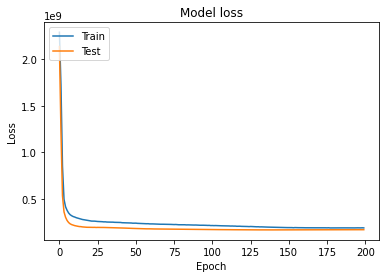

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# from keras.utils import plot_model
from keras.models import load_model
#保存模型
model.save('model_MLP.h5')  # creates a HDF5 file 'my_model.h5'
# 加载模型
model = load_model('model_MLP.h5')
# 预测
y_pred = model.predict(X_test)

In [ ]:
print("MSE:", mean_squared_error(y_true=y_test, y_pred=y_pred))
print("RMSE:", math.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² score:", r2_score(y_test, y_pred))